# Abstractive Text Summarization of Product Reviews

## Understanding the Problem Statement

Customer reviews can often be long and descriptive. Analyzing these reviews manually, as you can imagine, is really time-consuming. This is where the brilliance of Machine Learning can be applied to generate a summary for long reviews.

We will be working on [this](https://www.kaggle.com/grikomsn/amazon-cell-phones-reviews) dataset. Our objective here is to generate a summary for the Amazon Cell Phones reviews using the abstraction-based approach.

Let's look at the implementation.

## Import the Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import re
import os
import ssl
import pickle
import tensorflow as tf
import ipywidgets as widgets

from tqdm import tqdm
from bs4 import BeautifulSoup
from urllib import request
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from rouge import Rouge
from keras import backend as K
from keras.models import load_model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import backend as K
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

In [2]:
print('TensorFlow Version: {}'.format(tf.__version__))

TensorFlow Version: 2.3.1


In [3]:
device_name = tf.test.gpu_device_name()

if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')

print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Read the dataset

This dataset consists of reviews of cell phones from Amazon. These reviews include product and user information, ratings, date, plain text review, and summary. This dataset focuses on both unlocked and locked carriers, and scoped on ten brands: ASUS, Apple, Google, HUAWEI, Motorola, Nokia, OnePlus, Samsung, Sony, and Xiaomi.

In [41]:
data = pd.read_csv("datasets/cellphones_clean2.csv")

In [42]:
data.head()

,summary,text
0,I love it. I buy a new one every year,"As always, it is a quality calendar full of ve..."
1,I love all the space facts that this calendar has,I love all the space facts that this calendar ...
2,Nice wall calendar that i will enjoy and is al...,Very nice and delivered in a box which kept th...
3,"It is beautifully done, filled with interestin...","I have been buying this, and the desk calendar..."
4,All the extra cool facts and information about...,One of the coolest purchases I've ever made. I...


## Drop columns, duplicates and NA values

In [43]:
# data.drop(columns=['reviewerID', 'asin', 'reviewerName', 'helpful',
#                    'overall', 'unixReviewTime', 'reviewTime'], inplace=True)
# data.dropna(axis=0, inplace=True)

In [44]:
# data.rename(columns={'reviewText': 'text'}, inplace=True)

## Information about dataset

Let us look at data-types and shape of the dataset

In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2378257 entries, 0 to 2378256
Data columns (total 2 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   summary  object
 1   text     object
dtypes: object(2)
memory usage: 36.3+ MB


In [46]:
data.describe()

,summary,text
count,2378257,2378257
unique,2263577,2342131
top,You get what you pay for,ITS A VERY NICE PRODUCT... IT CAME AS I SPECTE...
freq,3969,39


## Preprocessing

Performing basic preprocessing steps is very important before we get to the model building part. Using messy and uncleaned text data is a potentially disastrous move. So in this step, we will drop all the unwanted symbols, characters, etc. from the text that do not affect the objective of our problem.

We will perform the below preprocessing tasks for our data:
1. Convert everything to lowercase
2. Remove HTML tags
3. Contraction mapping
4. Remove ('s)
5. Remove any text inside the parenthesis ( )
6. Eliminate punctuations and special characters
7. Remove stopwords
8. Remove short words

Here is the dictionary that we will use for expanding the contractions:

In [47]:
contraction_mapping = {"ain't": "is not", "aren't": "are not", "can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                       "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                       "he'd": "he would", "he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                       "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have", "I'm": "I am", "I've": "I have", "i'd": "i would",
                       "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have", "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                       "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have", "it's": "it is", "let's": "let us", "ma'am": "madam",
                       "mayn't": "may not", "might've": "might have", "mightn't": "might not", "mightn't've": "might not have", "must've": "must have",
                       "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have", "o'clock": "of the clock",
                       "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                       "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                       "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have", "so's": "so as",
                       "this's": "this is", "that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                       "there'd've": "there would have", "there's": "there is", "here's": "here is", "they'd": "they would", "they'd've": "they would have",
                       "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                       "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                       "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                       "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                       "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                       "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                       "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                       "y'all'd": "you all would", "y'all'd've": "you all would have", "y'all're": "you all are", "y'all've": "you all have",
                       "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                       "you're": "you are", "you've": "you have"}

In [48]:
stop_words = set(stopwords.words('english'))


def text_cleaner(text, num):
    newString = text.lower()
    newString = BeautifulSoup(newString, 'lxml').text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"', '', newString)
    newString = ' '.join(
        [contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(' ')])
    newString = re.sub(r"'s\b", '', newString)
    newString = re.sub("[^a-zA-Z]", ' ', newString)
    newString = re.sub('[m]{2,}', 'mm', newString)

    if(num == 0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens = newString.split()

    long_words = []

    for i in tokens:
        if len(i) > 1:
            long_words.append(i)

    return (' '.join(long_words)).strip()

In [49]:
cleaned_text = []

for t in tqdm(data['text']):
    cleaned_text.append(text_cleaner(t, 0))

100%|██████████████████████████████████████████████████████████████████████| 2378257/2378257 [10:10<00:00, 3897.46it/s]


Let us look at the first five preprocessed reviews

In [50]:
for i, c_t in enumerate(cleaned_text[:5]):
    print('Cleaned Text #{}'.format(i + 1))
    print(c_t)
    print()

Cleaned Text #1
always quality calendar full interesting space related photos information love buy new one every year

Cleaned Text #2
love space facts calendar one best space calendars found

Cleaned Text #3
nice delivered box kept calendar flat un creased new nice pictures detail

Cleaned Text #4
buying desk calendar well years beautifully done filled interesting facts easy use would recommend anyone

Cleaned Text #5
one coolest purchases ever made absolutely getting next year calendar well extra cool facts information everything space related make every day interesting even day space history tidbits squares moon phase indicators every day monthly sky guides viewing various planets interesting celestial bodies even coordinates telescopes learn something new every day sure calendar would absolutely reccomend



In [51]:
cleaned_summary = []

for t in tqdm(data['summary']):
    cleaned_summary.append(text_cleaner(t, 1))

100%|██████████████████████████████████████████████████████████████████████| 2378257/2378257 [08:47<00:00, 4508.00it/s]


Let us look at the first 10 preprocessed summaries

In [52]:
for i, c_s in enumerate(cleaned_summary[:5]):
    print('Cleaned Summary #{}'.format(i + 1))
    print(c_s)
    print()

Cleaned Summary #1
love it buy new one every year

Cleaned Summary #2
love all the space facts that this calendar has

Cleaned Summary #3
nice wall calendar that will enjoy and is also good for work

Cleaned Summary #4
it is beautifully done filled with interesting facts and easy to

Cleaned Summary #5
all the extra cool facts and information about everything space related make every day



In [53]:
data['cleaned_text'] = cleaned_text
data['cleaned_summary'] = cleaned_summary

## Drop empty rows

In [54]:
# data.replace('', np.nan, inplace=True)
# data.dropna(axis=0, inplace=True)

## Understanding the distribution of the sequences

Here, we will analyze the length of the reviews and the summary to get an overall idea about the distribution of length of the text. This will help us fix the maximum length of the sequence:

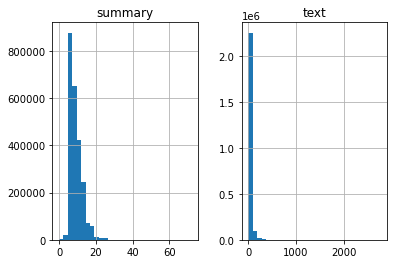

In [55]:
text_word_count = []
summary_word_count = []

for i in data['cleaned_text']:
    text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
    summary_word_count.append(len(i.split()))

length_df = pd.DataFrame(
    {'text': text_word_count, 'summary': summary_word_count})

length_df.hist(bins=30)
plt.show()

We can fix the maximum length of the summary to 12 since that seems to be the majority summary length.

Let us understand the proportion of the length of summaries below 12.

In [56]:
cnt = 0

for i in data['cleaned_summary']:
    if(len(i.split()) <= 20):
        cnt = cnt+1

print('{:.2%}'.format(cnt / len(data['cleaned_summary'])))

99.12%


We observe that 96% of the summaries have length below 12. So, we can fix maximum length of summary to 12.

Let us fix the maximum length of review to 30.

In [57]:
max_text_len = 50
max_summary_len = 20

Let us select the reviews and summaries whose length falls below or equal to **max_text_len** and **max_summary_len**

In [58]:
cleaned_text = np.array(data['cleaned_text'])
cleaned_summary = np.array(data['cleaned_summary'])

short_text = []
short_summary = []

for i in tqdm(range(len(cleaned_text))):
    if(len(cleaned_summary[i].split()) <= max_summary_len and len(cleaned_text[i].split()) <= max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])

df = pd.DataFrame({'text': short_text, 'summary': short_summary})

100%|████████████████████████████████████████████████████████████████████| 2378257/2378257 [00:08<00:00, 274156.25it/s]


We have to add the **START** and **END** special tokens at the beginning and end of the summary. Here, I have chosen **sostok** and **eostok** as START and END tokens

**Note:** We have to choose the special tokens which never appear in the summary.

In [59]:
df['summary'] = df['summary'].apply(lambda x: 'sostok ' + x + ' eostok')

We are getting closer to the model building part. Before that, we need to split our dataset into a training and validation set. We’ll use 90% of the dataset as the training data and evaluate the performance on the remaining 10% (holdout set):

In [78]:
x_tr, x_val, y_tr, y_val = train_test_split(np.array(df['text'][:100000]), np.array(
    df['summary'][:100000]), test_size=0.1, random_state=0, shuffle=True)

## Preparing the Tokenizer

A tokenizer builds the vocabulary and converts a word sequence to an integer sequence. Let's build the tokenizers for text and summary:

### Text Tokenizer

In [79]:
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

### Rarewords and its Coverage

Let us look at the proportion rare words and its total coverage in the entire text.

Here, I am defining the threshold to be 4 which means word whose count is below 4 is considered as a rare word.

In [80]:
thresh = 4
cnt = 0
tot_cnt = 0
freq = 0
tot_freq = 0

for key, value in x_tokenizer.word_counts.items():
    tot_cnt = tot_cnt + 1
    tot_freq = tot_freq + value

    if(value < thresh):
        cnt = cnt + 1
        freq = freq + value

print('% of rare words in vocabulary: {:.2%}'.format(cnt / tot_cnt))
print('Total Coverage of rare words: {:.2%}'.format(freq / tot_freq))

% of rare words in vocabulary: 64.02%
Total Coverage of rare words: 1.47%


* **tot_cnt** gives the size of vocabulary (which means every unique words in the text)
* **cnt** gives the no. of rare words whose count falls below threshold
* **tot_cnt - cnt** gives the top most common words 

Let us define the tokenizer with top most common words for reviews.

In [81]:
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt)
x_tokenizer.fit_on_texts(list(x_tr))

x_tr_seq = x_tokenizer.texts_to_sequences(x_tr)
x_val_seq = x_tokenizer.texts_to_sequences(x_val)

x_tr = pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val = pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

x_voc = x_tokenizer.num_words + 1

In [82]:
print('Size of the vocabulary: {}'.format(x_voc))

Size of the vocabulary: 11991


In [83]:
with open('x_tokenizer', 'wb') as f:
    pickle.dump(x_tokenizer, f)

### Summary Tokenizer

In [84]:
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

### Rarewords and its Coverage

Let us look at the proportion rare words and its total coverage in the entire summary

Here, I am defining the threshold to be 6 which means word whose count is below 6 is considered as a rare word.

In [88]:
thresh = 6
cnt = 0
tot_cnt = 0
freq = 0
tot_freq = 0

for key, value in y_tokenizer.word_counts.items():
    tot_cnt = tot_cnt + 1
    tot_freq = tot_freq + value
    if(value < thresh):
        cnt = cnt + 1
        freq = freq + value

print('% of rare words in vocabulary: {:.2%}'.format(cnt / tot_cnt))
print('Total Coverage of rare words: {:.2%}'.format(freq / tot_freq))

% of rare words in vocabulary: 73.13%
Total Coverage of rare words: 2.08%


Let us define the tokenizer with top most common words for summary.

In [86]:
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt)
y_tokenizer.fit_on_texts(list(y_tr))

y_tr_seq = y_tokenizer.texts_to_sequences(y_tr)
y_val_seq = y_tokenizer.texts_to_sequences(y_val)

y_tr = pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val = pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

y_voc = y_tokenizer.num_words + 1

Let us check whether word count of start token is equal to length of the training data

In [87]:
y_tokenizer.word_counts['sostok'], len(y_tr)

(90000, 90000)

In [89]:
with open('y_tokenizer', 'wb') as f:
    pickle.dump(y_tokenizer, f)

Here, I am deleting the rows that contain only **START** and **END** tokens

In [90]:
ind = []

for i in range(len(y_tr)):
    cnt = 0

    for j in y_tr[i]:
        if j != 0:
            cnt = cnt+1

    if(cnt == 2):
        ind.append(i)

y_tr = np.delete(y_tr, ind, axis=0)
x_tr = np.delete(x_tr, ind, axis=0)

In [91]:
ind = []

for i in range(len(y_val)):
    cnt = 0

    for j in y_val[i]:
        if j != 0:
            cnt = cnt+1

    if(cnt == 2):
        ind.append(i)

y_val = np.delete(y_val, ind, axis=0)
x_val = np.delete(x_val, ind, axis=0)

## Model building

**Return Sequences = True**: When the return sequences parameter is set to True, LSTM produces the hidden state and cell state for every timestep.

**Return State = True**: When return state = True, LSTM produces the hidden state and cell state of the last timestep only.

**Initial State**: This is used to initialize the internal states of the LSTM for the first timestep.

**Stacked LSTM**: Stacked LSTM has multiple layers of LSTM stacked on top of each other. 
This leads to a better representation of the sequence. I encourage you to experiment with the multiple layers of the LSTM stacked on top of each other (it's a great way to learn this).

Let's first build our AttentionLayer class:

In [92]:
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape(
                                       (input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape(
                                       (input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape(
                                       (input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs, verbose=False):
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs

        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            assert_msg = "States must be an iterable. Got {} of type {}".format(
                states, type(states))
            assert isinstance(states, list) or isinstance(
                states, tuple), assert_msg

            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            W_a_dot_s = K.dot(encoder_out_seq, self.W_a)

            U_a_dot_h = K.expand_dims(
                K.dot(inputs, self.U_a), 1)
            if verbose:
                print('Ua.h>', U_a_dot_h.shape)

            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)
            if verbose:
                print('Ws+Uh>', Ws_plus_Uh.shape)

            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            assert_msg = "States must be an iterable. Got {} of type {}".format(
                states, type(states))
            assert isinstance(states, list) or isinstance(
                states, tuple), assert_msg

            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)

            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)

        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        return [
            tf.TensorShape(
                (input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape(
                (input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

Here, we are building a 3 stacked LSTM for the encoder:

In [93]:
K.clear_session()

latent_dim = 300
embedding_dim = 100

encoder_inputs = Input(shape=(max_text_len,))

enc_emb = Embedding(x_voc, embedding_dim, trainable=True)(encoder_inputs)

encoder_lstm1 = Bidirectional(LSTM(latent_dim, return_sequences=True,
                                   return_state=True, dropout=0.4, recurrent_dropout=0.4))(enc_emb)
# [0], encoder_lstm1[2], encoder_lstm1[4], encoder_lstm1[3], encoder_lstm1[5]
encoder_output1, state_h1_forward, state_c1_forward, state_h1_backward, state_c1_backward = encoder_lstm1

encoder_lstm2 = Bidirectional(LSTM(latent_dim, return_sequences=True,
                                   return_state=True, dropout=0.4, recurrent_dropout=0.4))(encoder_output1)
# [0], encoder_lstm2[2], encoder_lstm2[4], encoder_lstm2[3], encoder_lstm2[5]
encoder_output2, state_h2_forward, state_c2_forward, state_h2_backward, state_c2_backward = encoder_lstm2

encoder_lstm3 = Bidirectional(LSTM(latent_dim, return_state=True,
                                   return_sequences=True, dropout=0.4, recurrent_dropout=0.4))(encoder_output2)
# [0], encoder_lstm3[2], encoder_lstm3[4], encoder_lstm3[3], encoder_lstm3[5]
encoder_outputs, state_h_forward, state_c_forward, state_h_backward, state_c_backward = encoder_lstm3
state_h = Concatenate()([state_h_forward, state_h_backward])
state_c = Concatenate()([state_c_forward, state_c_backward])

decoder_inputs = Input(shape=(None,))

dec_emb_layer = Embedding(y_voc, embedding_dim, trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim*2, return_sequences=True,
                    return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, decoder_fwd_state, decoder_back_state = decoder_lstm(
    dec_emb, initial_state=[state_h, state_c])

attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

decoder_concat_input = Concatenate(
    axis=-1, name='concat_layer')([decoder_outputs, attn_out])

decoder_dense = TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 100)      1199100     input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   [(None, 50, 600), (N 962400      embedding[0][0]                  
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) [(None, 50, 600), (N 2162400     bidirectional[0][0]              
_______________________________________________________________________________________

I am using sparse categorical cross-entropy as the loss function since it converts the integer sequence to a one-hot vector on the fly. This overcomes any memory issues.

In [94]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

Early Stopping is used to stop training the neural network at the right time by monitoring a user-specified metric. Here, I am monitoring the validation loss (val_loss). Our model will stop training once the validation loss increases:

In [95]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

We’ll train the model on a batch size of 128 and validate it on the holdout set (which is 10% of our dataset):

In [96]:
history = model.fit([x_tr, y_tr[:, :-1]], y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:, 1:], epochs=50, callbacks=[es],
                    batch_size=64, validation_data=([x_val, y_val[:, :-1]], y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:, 1:]))

Epoch 1/50
1407/1407 [==============================] - 2066s 1s/step - loss: 2.2460 - val_loss: 2.0740
Epoch 2/50
1407/1407 [==============================] - 1992s 1s/step - loss: 1.9372 - val_loss: 1.8870
Epoch 3/50
1407/1407 [==============================] - 1993s 1s/step - loss: 1.8301 - val_loss: 1.8182
Epoch 4/50
1407/1407 [==============================] - 1987s 1s/step - loss: 1.7625 - val_loss: 1.7861
Epoch 5/50
1407/1407 [==============================] - 1987s 1s/step - loss: 1.7125 - val_loss: 1.7585
Epoch 6/50
1407/1407 [==============================] - 1988s 1s/step - loss: 1.6730 - val_loss: 1.7474
Epoch 7/50
1407/1407 [==============================] - 1993s 1s/step - loss: 1.6391 - val_loss: 1.7217
Epoch 8/50
1407/1407 [==============================] - 1988s 1s/step - loss: 1.6123 - val_loss: 1.7499
Epoch 9/50
1407/1407 [==============================] - 1985s 1s/step - loss: 1.5883 - val_loss: 1.7121
Epoch 10/50
1407/1407 [==============================] - 1987s 1

## Save the Model

In [97]:
model.save('model.h5')

## Load the Model

In [98]:
# model = load_model('model.h5', custom_objects={'AttentionLayer': AttentionLayer})

## Understanding the Diagnostic plot

Now, we will plot a few diagnostic plots to understand the behavior of the model over time:

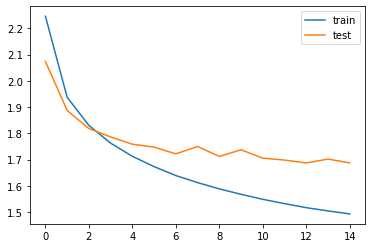

In [99]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

From the plot, we can infer that validation loss has increased after epoch 12 for 2 successive epochs. Hence, training is stopped at epoch 15.

Next, let's build the dictionary to convert the index to word for target and source vocabulary:

In [100]:
reverse_target_word_index = y_tokenizer.index_word
reverse_source_word_index = x_tokenizer.index_word
target_word_index = y_tokenizer.word_index

## Inference

Set up the inference for the encoder and decoder:

In [101]:
encoder_model = Model(inputs=encoder_inputs, outputs=[
                      encoder_outputs, state_h, state_c])

# Tensors to hold the states of previous timesteps
decoder_state_input_h = Input(shape=(latent_dim*2,))
decoder_state_input_c = Input(shape=(latent_dim*2,))
decoder_hidden_state_input = Input(shape=(max_text_len, latent_dim*2))

# Get the embeddings of the decoder sequence
dec_emb2 = dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(
    dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# Attention inference
attn_out_inf, attn_states_inf = attn_layer(
    [decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(
    axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

decoder_outputs2 = decoder_dense(decoder_inf_concat)

In [102]:
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,
                        decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [103]:
encoder_model.save('encoder_model.h5')
decoder_model.save('decoder_model.h5')

In [104]:
# encoder_model = load_model('encoder_model.h5')
# decoder_model = load_model('decoder_model.h5', custom_objects={'AttentionLayer': AttentionLayer})

We are defining a function below which is the implementation of the inference process (which we covered [here](https://www.analyticsvidhya.com/blog/2019/06/comprehensive-guide-text-summarization-using-deep-learning-python/)):

In [105]:
def beam_search_decoder(data, k=3):
    sequences = [[list(), 0.0]]

    for row in data:
        all_candidates = list()

        for i in range(len(sequences)):
            seq, score = sequences[i]

            for j in range(len(row)):
                candidate = [seq + [j], score - np.log(row[j])]
                all_candidates.append(candidate)

        ordered = sorted(all_candidates, key=lambda tup:tup[1])
        sequences = ordered[:k]

    return sequences

In [106]:
def decode_sequence(input_seq):
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = target_word_index['sostok']
    stop_condition = False
    decoded_sentence = ''
   
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmin(beam_search_decoder(output_tokens)[0][1])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token != 'eostok'):
            decoded_sentence += ' ' + sampled_token

        if (sampled_token == 'eostok' or len(decoded_sentence.split()) >= (max_summary_len - 1)):
            stop_condition = True

        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index
        e_h, e_c = h, c

    return decoded_sentence.strip()

Let us define the functions to convert an integer sequence to a word sequence for summary as well as the reviews:

In [107]:
def seq2summary(input_seq):
    newString = ''

    for i in input_seq:
        if((i != 0 and i != target_word_index['sostok']) and i != target_word_index['eostok']):
            newString = newString + reverse_target_word_index[i] + ' '

    return newString


def seq2text(input_seq):
    newString = ''

    for i in input_seq:
        if(i != 0):
            newString = newString + reverse_source_word_index[i] + ' '

    return newString

Let's analyze our model using BLEU score and ROUGE score.

In [108]:
analyser = SentimentIntensityAnalyzer()


def sentiment_analyzer_scores(sentence):
    score = analyser.polarity_scores(sentence)
    return dict(list(score.items())[:-1])

Here are a few summaries generated by the model:

In [109]:
for i in range(5):
    print('Review:', seq2text(x_tr[i]))
    print('Original Summary:', seq2summary(y_tr[i]))
    print('Predicted Summary:', decode_sequence(
        x_tr[i].reshape(1, max_text_len)))
    print('Sentiment Score:', sentiment_analyzer_scores(decode_sequence(
        x_tr[i].reshape(1, max_text_len))))
    print()

Review: types cases fit tightly although colors great would better product made smaller fit phone better 
Original Summary: very loose fit but great color 
Predicted Summary: not as good as the picture
Sentiment Score: {'neg': 0.325, 'neu': 0.675, 'pos': 0.0}

Review: ordered phone son broke iphone want spend lot money one cheap would work verizon got phone yesterday white described listing black honestly care color set working great looks brand new even one scratch dent happy customer 
Original Summary: the one got was black not white but it works great 
Predicted Summary: great phone case for the new phone
Sentiment Score: {'neg': 0.0, 'neu': 0.594, 'pos': 0.406}

Review: dilemma put high quality leather case metal fittings snaps plastic something ultimately fail although case metal snap fittings hold flap phone fitting flap held place leather leather gave way one day way get back case months guess could say lasted others still waiting case built last 
Original Summary: not sure what

## Making prediction

In [110]:
test_inp = ['Screen Size is Small but the Camera Quality is Excellent.',
            'Packaging was bad... The phone is small and is not working. Bad choice!!!',
            'The phone is great and amazingly fast. The processor doesn\'t gets heated up because of the liquid cool technology. Five stars.',
            'Don\'t buy it. It\'s a scam. They are trolling people for money. Apple has always been like this. No charger.']

test_inp_seq = x_tokenizer.texts_to_sequences(test_inp)
test_inp_seq = pad_sequences(test_inp_seq, maxlen=max_text_len, padding='post')

In [111]:
for i in range(len(test_inp_seq)):
    print('Actual Review:', test_inp[i])
    print('Cleaned Review:', seq2text(test_inp_seq[i]))
    print('Predicted summary:', decode_sequence(
        test_inp_seq[i].reshape(1, max_text_len)).strip())
    print('Sentiment Score:', sentiment_analyzer_scores(test_inp[i]))
    print()

Actual Review: Screen Size is Small but the Camera Quality is Excellent.
Cleaned Review: screen size small camera quality excellent 
Predicted summary: small size and small enough for the small size
Sentiment Score: {'neg': 0.0, 'neu': 0.641, 'pos': 0.359}

Actual Review: Packaging was bad... The phone is small and is not working. Bad choice!!!
Cleaned Review: packaging bad phone small working bad choice 
Predicted summary: the phone is bad the bad bad bad
Sentiment Score: {'neg': 0.24, 'neu': 0.604, 'pos': 0.156}

Actual Review: The phone is great and amazingly fast. The processor doesn't gets heated up because of the liquid cool technology. Five stars.
Cleaned Review: phone great amazingly fast processor gets heated liquid cool technology five stars 
Predicted summary: the phone is great fast and fast
Sentiment Score: {'neg': 0.0, 'neu': 0.748, 'pos': 0.252}

Actual Review: Don't buy it. It's a scam. They are trolling people for money. Apple has always been like this. No charger.
Cle

In [112]:
from difflib import SequenceMatcher

def match(a, b):
    return SequenceMatcher(None, a, b).ratio()

In [113]:
decoded_sentences = []

for i in range(len(test_inp_seq)):
    decoded_sentences.append({decode_sequence(test_inp_seq[i].reshape(
        1, max_text_len)).strip(): sentiment_analyzer_scores(test_inp[i])})

In [114]:
pos_abstract_summary, neg_abstract_summary = [], []

for i in range(len(decoded_sentences)):
    for j in range(len(decoded_sentences)):
        if not decoded_sentences[i] == decoded_sentences[j]:
            if match([*decoded_sentences[i].keys()][0], [*decoded_sentences[j].keys()][0]) < 0.5:
                if [*decoded_sentences[i].values()][0]['neg'] < [*decoded_sentences[i].values()][0]['pos']:
                    pos_abstract_summary.append([*decoded_sentences[i].keys()][0])
                else:
                    neg_abstract_summary.append([*decoded_sentences[i].keys()][0])
                break

In [115]:
print('. '.join([i.capitalize() for i in pos_abstract_summary]))
print('. '.join([i.capitalize() for i in neg_abstract_summary]))

Small size and small enough for the small size. The phone is great fast and fast
The phone is bad the bad bad bad. Do not buy this if you want to replace your apple apple iphone


Even though the actual summary and the summary generated by our model do not match in terms of words, both of them are conveying the same meaning. Our model is able to generate a legible summary based on the context present in the text.

## Future work

- Implement **Pointer-Generator Networks** and **Copy and Coverage Mechanisms** for better summary generation.
- Implement **BERT** instead of **Bidirectional LSTM**.
- Implement **Teacher Forcing strategy** while training **RNN**.